In [1]:
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
%matplotlib notebook

In [52]:
window_size = 250
pre_filtering_thresh = 0.1
percent = 0.1
means_init = [
              [[0.7], [0.3]],
              [[0.7], [0.2]],
              [[0.7], [0.2]]
             ]

In [3]:
data = np.load("scores_fg_uc_bg_split_1_1.pkl", allow_pickle=True)
df = pd.DataFrame.from_dict(data)
df

,iou_roi_pl,iou_roi_gt,pred_scores,weights,class_labels,iteration
0,0.875758,0.867100,8.249064,1.000000,1,0.0
1,0.863749,0.707947,9.722204,1.000000,1,0.0
2,0.855936,0.768268,10.525517,0.999976,1,0.0
3,0.840970,0.871486,10.946503,1.000000,1,0.0
4,0.835199,0.650061,2.111903,0.996701,1,0.0
...,...,...,...,...,...,...
708987,0.000000,0.000000,-1.759575,0.897422,1,1439.0
708988,0.000000,0.000000,-9.024330,0.363668,1,1439.0
708989,0.000000,0.000000,-13.350929,0.988542,1,1439.0
708990,0.000000,0.197835,-11.565997,0.999289,1,1439.0


<IPython.core.display.Javascript object>


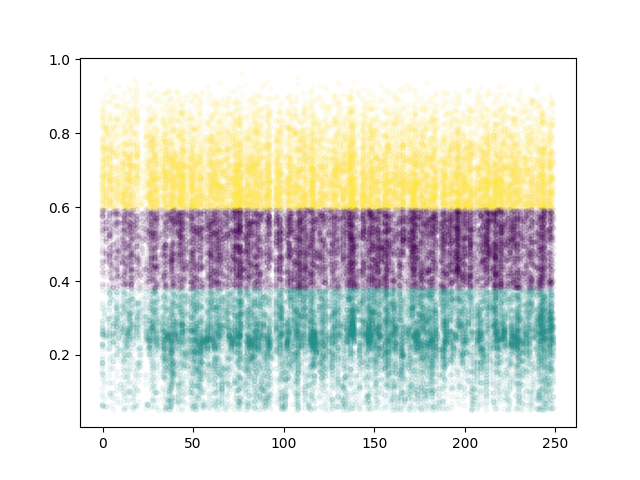

In [28]:
plt.clf()
i = 0
cls = 0

iter_mask = (i <= df['iteration']) & (df['iteration'] < i + window_size)
cls_mask = df['class_labels'] == cls+1
filter_mask = pre_filtering_thresh < df['iou_roi_pl']
mask = iter_mask & cls_mask & filter_mask

roi_ious_pl = df[mask]['iou_roi_pl']
iterations = df[mask]['iteration']


labels = GaussianMixture(n_components=3).fit(roi_ious_pl.values.reshape(-1, 1)).predict(roi_ious_pl.values.reshape(-1, 1))
plt.scatter(iterations, roi_ious_pl, s=10, alpha=0.05, c=labels)


<IPython.core.display.Javascript object>


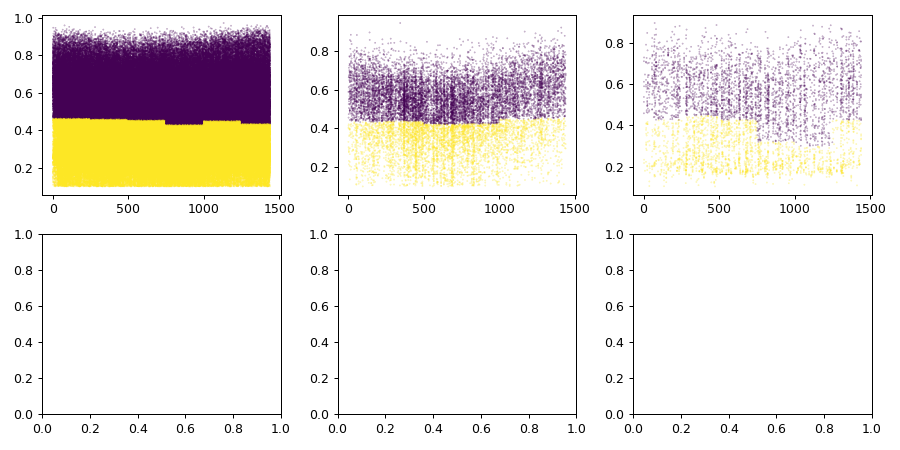

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

classwise_threshs_comp1_lower = [[] for _ in range(3)]
classwise_threshs_comp1_upper = [[] for _ in range(3)]
classwise_threshs_comp2_lower = [[] for _ in range(3)]
classwise_threshs_comp2_upper = [[] for _ in range(3)]

for cls in range(3):
    # Fit a Gaussian and draw densities
    max_iter = int(df['iteration'].max())
    for step, i in enumerate(range(0, max_iter, window_size)):
        iter_mask = (i <= df['iteration']) & (df['iteration'] < i + window_size)
        cls_mask = df['class_labels'] == cls+1
        filter_mask = pre_filtering_thresh < df['iou_roi_pl']
        mask = iter_mask & cls_mask & filter_mask
#         mask = iter_mask & cls_mask
                     
        roi_ious_pl = df[mask]['iou_roi_pl']
        iterations = df[mask]['iteration']
        
        
        labels = GaussianMixture(n_components=2, means_init=means_init[cls]).fit(roi_ious_pl.values.reshape(-1, 1)).predict(roi_ious_pl.values.reshape(-1, 1))
        axes[0][cls].scatter(iterations.astype(int), roi_ious_pl, s=0.1, alpha=0.5, c=labels)
#         mu, sigma = norm.fit(roi_ious_pl)
#         lower_bound_iou_comp1 = norm.ppf(percent, loc=gm.means_[0], scale=gm.covariances_[0])
#         upper_bound_iou_comp1 = norm.ppf(1 - percent, loc=gm.means_[0], scale=gm.covariances_[0])
        
#         lower_bound_iou_comp2 = norm.ppf(percent, loc=gm.means_[1], scale=gm.covariances_[1])
#         upper_bound_iou_comp2 = norm.ppf(1 - percent, loc=gm.means_[1], scale=gm.covariances_[1])
        
#         classwise_threshs_comp1_lower[cls].append(lower_bound_iou_comp1.item())
#         classwise_threshs_comp1_upper[cls].append(upper_bound_iou_comp1.item())
        
#         classwise_threshs_comp2_lower[cls].append(lower_bound_iou_comp2.item())
#         classwise_threshs_comp2_upper[cls].append(upper_bound_iou_comp2.item())
        
#         x = np.linspace(0, 1, 100)
#         comp1_pdf = norm.pdf(x, gm.means_[0], gm.covariances_[0])
#         comp2_pdf = norm.pdf(x, gm.means_[1], gm.covariances_[1])
#         width = step * 0.3 + 0.2
#         axes[1][cls].plot(x, comp1_pdf.reshape(-1), 'k', linewidth=width, alpha=0.5, color='orange')
#         axes[1][cls].plot(x, comp2_pdf.reshape(-1), 'k', linewidth=width, alpha=0.5, color='black')

        
# for cls in range(3):
#     axes[0][cls].plot(df[iter_mask]['iteration'], classwise_threshs_comp1_lower[cls], c='blue')
#     axes[0][cls].plot(df[iter_mask]['iteration'], classwise_threshs_comp1_upper[cls], c='blue')
    
#     axes[0][cls].plot(df[iter_mask]['iteration'], classwise_threshs_comp2_lower[cls], c='red')
#     axes[0][cls].plot(df[iter_mask]['iteration'], classwise_threshs_comp2_upper[cls], c='red')
    
fig.tight_layout()